In [56]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import matplotlib.colors as colors
fname='/Users/mgrecu/WDomains/MCS_OK/wrfout_d03_2018-06-25_07:00:00'
with nc.Dataset(fname) as fh:
    qrain=fh.variables['QRAIN'][:,:,:]
    ncrain=fh.variables['QNRAIN'][:,:,:]
    qice=fh.variables['QICE'][:,:,:]
    ncice=fh.variables['QNICE'][:,:,:]
    qir=fh.variables['QIR'][:,:,:]
    xlon=fh.variables['XLONG'][0,:,:]
    xlat=fh.variables['XLAT'][0,:,:]
    height=fh.variables['PHB'][:,:,:,:]+fh.variables['PH'][0,:,:,:]
    sfc_height=fh.variables['HGT'][0,:,:]
    theta=fh.variables['T'][:,:,:,:]+300.
    p=fh.variables['P'][:,:,:,:]+fh.variables['PB'][:,:,:,:]
    rainnc=fh.variables['RAINNC'][:,:,:]
    #print(fh.variables['RAINNC'])
    t=theta*(p/100000.)**0.286
    #print(fh.variables['QIR'])
    rho=p/(287.*t)
    qv=fh.variables['QVAPOR'][:,:,:]
print(qrain.shape)
#print(rho[0,:,0,0])

(4, 83, 189, 201)


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


(4, 189, 201)


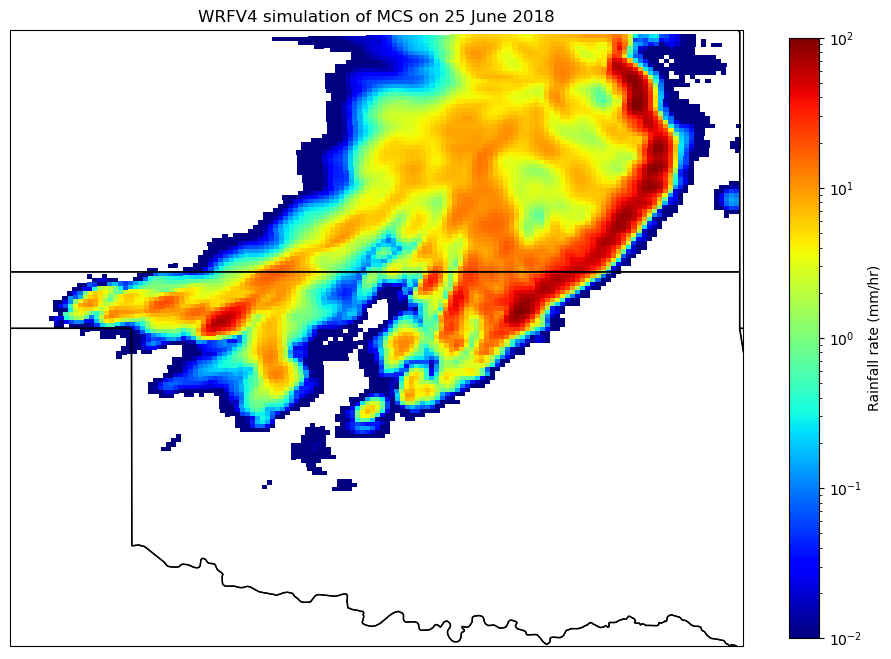

In [34]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(xlon[40:,50:190],xlat[40:,50:190],(rainnc[-1,40:,50:190]-rainnc[-2,40:,50:190])*4,cmap='jet',norm=colors.LogNorm(vmin=0.01,vmax=100.))
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
#add states
ax.add_feature(cfeature.STATES)
plt.title('WRFV4 simulation of MCS on 25 June 2018')
plt.colorbar(orientation='vertical',shrink=0.975,label='Rainfall rate (mm/hr)')
plt.tight_layout
print(rainnc.shape)
plt.savefig('WRF_sfc_rainfall_20180625.png',dpi=300)

In [23]:
#ny_sect=130
#plt.figure(figsize=(12,6))
#plt.pcolormesh(xlon[ny_sect,:],height[0,:-1,ny_sect,100]/9.81e3,((qir/(qice+1e-9))[0,:,ny_sect,:]),cmap='jet',)#,norm=colors.LogNorm(vmin=1e-6,vmax=6e-3),cmap='jet')
#plt.colorbar()
#print((qir.max(),qice.max()))
#plt.ylim([0,15])
#a=np.nonzero(qir>0.003)
#plt.figure()
#plt.scatter(qir[a],qice[a])
#print(np.corrcoef(qir[a],qice[a]))
#plt.figure()
#plt.hist(qir[a]/qice[a],bins=100)


In [63]:
import lkTables
import libScatter as libSc
import numpy as np
lkTables=lkTables.scattTables() 
from bisectm import bisectm
it=0
a=np.nonzero(qrain[it,0,:,:]>-1e-5)
print(a[0].shape)
print(nx*ny)
rhoice=100.0
nz=qrain.shape[1]
nz80=80
qice_1d=np.zeros((nz80),float)
dmice_1d=np.zeros((nz80),float)
qrain_1d=np.zeros((nz80),float)
ncice_1d=np.zeros((nz80),float)
zKuSim=np.zeros((nz80),float)
zKaSim=np.zeros((nz80),float)
zKu_true=np.zeros((nz80),float)
zKa_true=np.zeros((nz80),float)
nt,nz,ny,nx=qrain.shape
piaKu2D=np.zeros((ny,nx),float)
piaKa2D=np.zeros((ny,nx),float)
nfreqm=8

kext3D=np.zeros((nz80,ny,nx,nfreqm),float)
salb3D=np.zeros((nz80,ny,nx,nfreqm),float)
asym3D=np.zeros((nz80,ny,nx,nfreqm),float)
t3D=np.zeros((nz80+1,ny,nx),float)
btemp2d=np.zeros((ny,nx),float)

for i,j in zip(a[0],a[1]):
    qice_1dtmp=qice[it,:,i,j].copy()
    qrain_1dtmp=qrain[it,:,i,j].copy()
    dmice_1dtmp=qice[it,:,i,j].copy()*0
    dmrain_1dtmp=qrain[it,:,i,j].copy()*0
    hm=(height[it,1:,i,j]+height[it,:-1,i,j])/2/9.81e3
    hgrid=height[it,0,i,j]/9.81e3+np.arange(nz80)*0.25+0.125
    rwc_1d=np.interp(hgrid,hm,qrain[it,:,i,j]*rho[it,:,i,j]*1e3)
    iwc_1d=np.interp(hgrid,hm,qice[it,:,i,j]*rho[it,:,i,j]*1e3)
    for k1 in range(nz-1,-1,-1):
        attKu=0
        attKa=0
        zku=0
        if(qice[it,k1,i,j]>1e-5):
            dmice=4/(ncice[it,k1,i,j]*3.1415*rhoice/qice[it,k1,i,j])**0.333*1e3
            dmice_1dtmp[k1]=dmice
        if(qrain[it,k1,i,j]>1e-5):
            dmrain=4/(ncrain[it,k1,i,j]*3.1415*1000/qrain[it,k1,i,j])**0.333*1e3
            dmrain_1dtmp[k1]=dmrain
    dmice_1d=np.interp(hgrid,hm,dmice_1dtmp)
    dmrain_1d=np.interp(hgrid,hm,dmrain_1dtmp)
    nfreqm=8
    kext1D=np.zeros((nz80,nfreqm),float)
    salb1D=np.zeros((nz80,nfreqm),float)
    asym1D=np.zeros((nz80,nfreqm),float)
    kextAtmAllFreq=[]
    for freq in [10.6,18.7,23.,37.,89,166,186,190]:
        kextatm=[]
        for k1 in range(nz):
            ireturn=0
            absair,abswv = libSc.gasabsr98(freq,t[it,k1,i,j],qv[it,k1,i,j]*rho[it,k1,i,j],p[it,k1,i,j],ireturn)
            kextatm.append(absair+abswv)
        kextAtmAllFreq.append(kextatm)
    kextAtmAllFreq=np.array(kextAtmAllFreq).T
        
    piaKu=0
    piaKa=0
    dr=0.25
    for k1 in range(nz80-1,-1,-1):
        attKu=0
        attKa=0
        zku=0
        zka=0
        dmice_1d[k1]=max(lkTables.dms[0],dmice_1d[k1])
        dmice_1d[k1]=min(dmice_1d[k1],lkTables.dms[-1])
        dmrain_1d[k1]=max(lkTables.dmr[0],dmrain_1d[k1])
        dmrain_1d[k1]=min(dmrain_1d[k1],lkTables.dmr[-1])
        if iwc_1d[k1]>0:
            #ind=bisectm(lkTables.gwc.data,272,gwc[k1]/10**dng)
            ind=bisectm(lkTables.dms.data,253,dmice_1d[k1])
            dn_ice=np.log10(iwc_1d[k1]/lkTables.gwc.data[ind])
            zKu_ice=lkTables.zKuS[ind]+10*dn_ice
            zKa_ice=lkTables.zKaS[ind]+10*dn_ice
            attKu_ice=lkTables.attKuS[ind]*10**dn_ice
            attKa_ice=lkTables.attKaS[ind]*10**dn_ice
            attKu+=attKu_ice
            attKa+=attKa_ice
            zku+=10**(0.1*zKu_ice)
            zka+=10**(0.1*zKa_ice)
            kext1D[k1,:]+=lkTables.kextS[ind,:]*10**dn_ice
            salb1D[k1,:]+=lkTables.kextS[ind,:]*10**dn_ice*lkTables.salbS[ind,:]
            asym1D[k1,:]+=lkTables.kextS[ind,:]*10**dn_ice*lkTables.salbS[ind,:]*lkTables.asymS[ind,:]
        
        if rwc_1d[k1]>0:
            ind=bisectm(lkTables.dmr.data,289,dmrain_1d[k1])
            dnr=np.log10(rwc_1d[k1]/lkTables.rwc.data[ind])
            zKur=lkTables.zKuR[ind]+10*dnr
            zKar=lkTables.zKaR[ind]+10*dnr
            attKur=lkTables.attKuR[ind]*10**dnr
            attKar=lkTables.attKaR[ind]*10**dnr
            attKu+=attKur
            attKa+=attKar
            zku+=10**(0.1*zKur)
            zka+=10**(0.1*zKar)
            kext1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr
            salb1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]
            asym1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]*lkTables.asymR[ind,:]
        if attKu>0:
            piaKu+=attKu*dr
            piaKa+=attKa*dr
            zKuSim[k1]=10*np.log10(zku)-piaKu
            zKaSim[k1]=10*np.log10(zka)-piaKa
            zKu_true[k1]=10*np.log10(zku)
            zKa_true[k1]=10*np.log10(zka)
            piaKu+=attKu*dr
            piaKa+=attKa*dr
    piaKu2D[i,j]=piaKu
    piaKa2D[i,j]=piaKa
    umu=np.cos(53/180*3.1415)
    btemp=t[it,0,i,j]
    nz81=nz80+1
    hgrid1=height[it,0,i,j]/9.81e3+np.arange(nz81)*0.25
    lyrtemp=np.interp(hgrid1,hm,t[it,:,i,j])
    lyrhgt=hgrid1
    tboutL=[]
    for ifreq in range(nfreqm):
        kext=kext1D[:,ifreq]+np.interp(hgrid,hm,kextAtmAllFreq[:,ifreq])
        salb=salb1D[:,ifreq]
        asym=asym1D[:,ifreq]
        asalb=np.nonzero(salb>1e-3)
        asym[asalb]=asym[asalb]/salb[asalb]
        salb/=kext
        fisot=2.7
        emis=0.98
        ebar=0.98
        tbout = libSc.radtran(umu,btemp,lyrtemp,lyrhgt,kext,salb,asym,fisot,emis,ebar)
        tboutL.append(tbout)
        kext3D[:,i,j,ifreq]=kext
        salb3D[:,i,j,ifreq]=salb
        asym3D[:,i,j,ifreq]=asym
        t3D[:,i,j]=lyrtemp
        btemp2d[i,j]=btemp
    #break
    #break

(37989,)
37989


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_17187/3018197497.py:49: RuntimeWarning: invalid value encountered in scalar power
  dmrain=4/(ncrain[it,k1,i,j]*3.1415*1000/qrain[it,k1,i,j])**0.333*1e3


In [70]:
import xarray as xr 

kext3D=xr.DataArray(np.array(kext3D),dims=['nz','ny','nx','nfreq'],coords={'nfreq':[10.65,18.7,23.8,35.5,89,166,186,190],'ny':np.arange(ny),'nx':np.arange(nx),'nz':np.arange(nz80)})
salb3D=xr.DataArray(np.array(salb3D),dims=['nz','ny','nx','nfreq'],coords={'nfreq':[10.65,18.7,23.8,35.5,89,166,186,190],'ny':np.arange(ny),'nx':np.arange(nx),'nz':np.arange(nz80)})
asym3D=xr.DataArray(np.array(asym3D),dims=['nz','ny','nx','nfreq'],coords={'nfreq':[10.65,18.7,23.8,35.5,89,166,186,190],'ny':np.arange(ny),'nx':np.arange(nx),'nz':np.arange(nz80)})
t3D=xr.DataArray(np.array(t3D),dims=['nz1','ny','nx'],coords={'ny':np.arange(ny),'nx':np.arange(nx),'nz1':np.arange(nz80+1)})

piaKu2D=xr.DataArray(np.array(piaKu2D),dims=['ny','nx'],coords={'ny':np.arange(ny),'nx':np.arange(nx)})
piaKa2D=xr.DataArray(np.array(piaKa2D),dims=['ny','nx'],coords={'ny':np.arange(ny),'nx':np.arange(nx)})
xlon2D=xr.DataArray(np.array(xlon),dims=['ny','nx'],coords={'ny':np.arange(ny),'nx':np.arange(nx)})
xlat2D=xr.DataArray(np.array(xlat),dims=['ny','nx'],coords={'ny':np.arange(ny),'nx':np.arange(nx)})
#zKuSim=xr.DataArray(np.array(zKuSim),dims=['nz','ny','nx'],coords={'ny':np.arange(ny),'nx':np.arange(nx),'nz':np.arange(nz80)})
#zKaSim=xr.DataArray(np.array(zKaSim),dims=['nz','ny','nx'],coords={'ny':np.arange(ny),'nx':np.arange(nx),'nz':np.arange(nz80)})
#zKu_true=xr.DataArray(np.array(zKu_true),dims=['nz','ny','nx'],coords={'ny':np.arange(ny),'nx':np.arange(nx),'nz':np.arange(nz80)})
#zKa_true=xr.DataArray(np.array(zKa_true),dims=['nz','ny','nx'],coords={'ny':np.arange(ny),'nx':np.arange(nx),'nz':np.arange(nz80)})

ds=xr.Dataset({'kext':kext3D,'salb':salb3D,'asym':asym3D,'t':t3D,'piaKu':piaKu2D,'piaKa':piaKa2D,'xlon':xlon2D,'xlat':xlat2D})#,'zKuSim':zKuSim,'zKaSim':zKaSim,#'zKu_true':zKu_true,'zKa_true':zKa_true})
#'zKuSim':{'zlib':True,'complevel':5},'zKaSim':{'zlib':True,'complevel':5},'zKu_true':{'zlib':True,'complevel':5},'zKa_true':{'zlib':True,'complevel':5}

ds.to_netcdf('WRF_MCS_20180625_07:00_%2.2i.nc'%it,encoding={'kext':{'zlib':True,'complevel':5},'salb':{'zlib':True,'complevel':5},'asym':{'zlib':True,'complevel':5},'t':{'zlib':True,'complevel':5},'piaKu':{'zlib':True,'complevel':5},'piaKa':{'zlib':True,'complevel':5}})


In [62]:
print(tboutL)
print(k1,j,i)

[291.3891296386719, 291.47705078125, 291.4763488769531, 290.8309326171875, 291.1346435546875, 290.7900390625, 267.8258056640625, 281.98614501953125]
0 189 0


(253,)
0.19289566198086758 1.8596343485876692
4820


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


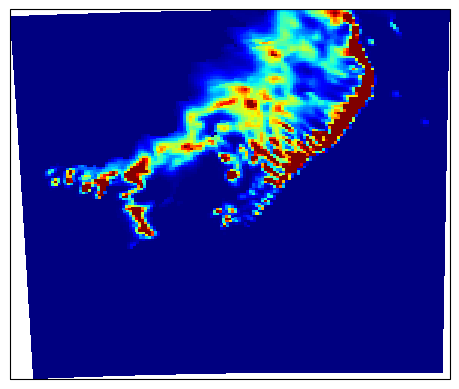

In [55]:
print(lkTables.dms.shape)
print(piaKu,piaKa)
print(len(a[0]))
ax=plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(xlon[40:,50:190],xlat[40:,50:190],piaKu2D[40:,50:190],cmap='jet',vmin=0,vmax=10)

In [38]:
print(dmrain_1d[0:10])
print(qrain_1d[0:10])

[2.33312035 2.26003335 2.21370207 2.19996956 2.2002967  2.2040573
 2.19120932 2.11906305 2.01338308 1.89362918]
[1.13388538 0.9660229  0.80279466 0.68025697 0.58613281 0.51342931
 0.46297413 0.44625624 0.45097042 0.46934215]


In [ ]:


def simZKu(gwc,swc,rwc,dmg,dms,dmr,dr):
    n1=gwc.shape[0]
    piaKu=0
    piaKa=0
    zKuSim=np.zeros((n1),float)-99
    zKu_true=np.zeros((n1),float)-99
    zKaSim=np.zeros((n1),float)-99
    zKa_true=np.zeros((n1),float)-99
    kexttot=np.zeros((n1),float)
    salbtot=np.zeros((n1),float)
    asymtot=np.zeros((n1),float)
    
    nfreqm=8
    kext1D=np.zeros((n1,nfreqm),float)
    salb1D=np.zeros((n1,nfreqm),float)
    asym1D=np.zeros((n1,nfreqm),float)
    for k1 in range(n1-1,-1,-1):
        attKu=0
        attKa=0
        zku=0
        zka=0
        dns=0
        dng=0
        if k1<40:
            dns=-(40-max(k1,22))*0.075
        if k1<80 and k1>0:
            dng=-(24-k1)*0.075
        dng=max(-0.97,dng)
        dng=min(0.97,dng)
        #dns=0
        #dng=0
        dms[k1]=max(lkTables.dms[0],dms[k1])
        dms[k1]=min(dms[k1],lkTables.dms[-1])
        dmg[k1]=max(lkTables.dmg[0],dmg[k1])
        dmg[k1]=min(dmg[k1],lkTables.dmg[-1])
        dmr[k1]=max(lkTables.dmr[0],dmr[k1])
        dmr[k1]=min(dmr[k1],lkTables.dmr[-1])
        if gwc[k1]>0:
            #ind=bisectm(lkTables.gwc.data,272,gwc[k1]/10**dng)
            ind=bisectm(lkTables.dmg.data,272,dmg[k1])
            dng=np.log10(gwc[k1]/lkTables.gwc.data[ind])
            zKug=lkTables.zKuG[ind]+10*dng
            zKag=lkTables.zKaG[ind]+10*dng
            attKug=lkTables.attKuG[ind]*10**dng
            attKag=lkTables.attKaG[ind]*10**dng
            attKu+=attKug
            attKa+=attKag
            zku+=10**(0.1*zKug)
            zka+=10**(0.1*zKag)
            kext1D[k1,:]+=lkTables.kextG[ind,:]*10**dng
            salb1D[k1,:]+=lkTables.kextG[ind,:]*10**dng*lkTables.salbG[ind,:]
            asym1D[k1,:]+=lkTables.kextG[ind,:]*10**dng*lkTables.salbG[ind,:]*lkTables.asymG[ind,:]
        if swc[k1]>0:
            ind=bisectm(lkTables.dms.data,253,dms[k1])
            dns=np.log10(swc[k1]/lkTables.swc.data[ind])
            zKus=lkTables.zKuS[ind]+10*dns
            zKas=lkTables.zKaS[ind]+10*dns
            attKus=lkTables.attKuS[ind]*10**dns
            attKas=lkTables.attKaS[ind]*10**dns
            attKu+=attKus
            attKa+=attKas
            zku+=10**(0.1*zKus)
            zka+=10**(0.1*zKas)
            kext1D[k1,:]+=lkTables.kextS[ind,:]*10**dns
            salb1D[k1,:]+=lkTables.kextS[ind,:]*10**dns*lkTables.salbS[ind,:]
            asym1D[k1,:]+=lkTables.kextS[ind,:]*10**dns*lkTables.salbS[ind,:]*lkTables.asymS[ind,:]
        if rwc[k1]>0:
            ind=bisectm(lkTables.dmr.data,289,dmr[k1])
            dnr=np.log10(rwc[k1]/lkTables.rwc.data[ind])
            #ind=bisectm(lkTables.rwc.data,289,rwc[k1])
            zKur=lkTables.zKuR[ind]+10*dnr
            zKar=lkTables.zKaR[ind]+10*dnr
            attKur=lkTables.attKuR[ind]*10**dnr
            attKar=lkTables.attKaR[ind]*10**dnr
            attKu+=attKur
            attKa+=attKar
            zku+=10**(0.1*zKur)
            zka+=10**(0.1*zKar)
            kext1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr
            salb1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]
            asym1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]*lkTables.asymR[ind,:]
        if attKu>0:
            piaKu+=attKu*dr
            piaKa+=attKa*dr
            zKuSim[k1]=10*np.log10(zku)-piaKu
            zKaSim[k1]=10*np.log10(zka)-piaKa
            zKu_true[k1]=10*np.log10(zku)
            zKa_true[k1]=10*np.log10(zka)
            piaKu+=attKu*dr
            piaKa+=attKa*dr
    kexttot[:]=kext1D[:,3]+1e-4
    salbtot[:]=salb1D[:,3]#/kexttot[:]
    asymtot[:]=asym1D[:,3]/(salb1D[:,3]+1e-4)      
    n1=80
    noms=0
    alt=400
    freqKa=35.5
    nonorm=1
    theta=0.5
    #print(kexttot[0:n1].sum()*dr*4.343*2,piaKa)
    #print(salbtot.max(),salbtot.min())
    #print(asymtot.max(),asymtot.min())
    #stop
    zms = libSc.multiscatterf(kexttot[0:n1][::-1],salbtot[0:n1][::-1],asymtot[0:n1][::-1],\
                            zKa_true[0:n1][::-1],dr,noms,alt,theta,freqKa,nonorm)
    
    return zKuSim,zKu_true,piaKu,zKaSim,zKa_true,piaKa,zms[::-1]


(189, 201)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_78533/2774462772.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(xlon[ny1:,:nx1],xlat[ny1:,:nx1],qrain[0,0,ny1:,:nx1],cmap='jet',norm=colors.LogNorm(vmin=1e-5))
/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_78533/2774462772.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(xlon[ny1:,:nx1],xlat[ny1:,:nx1],qrain[-1,0,ny1:,:nx1],cmap='jet',norm=colors.LogNorm(vmin=1e-5))


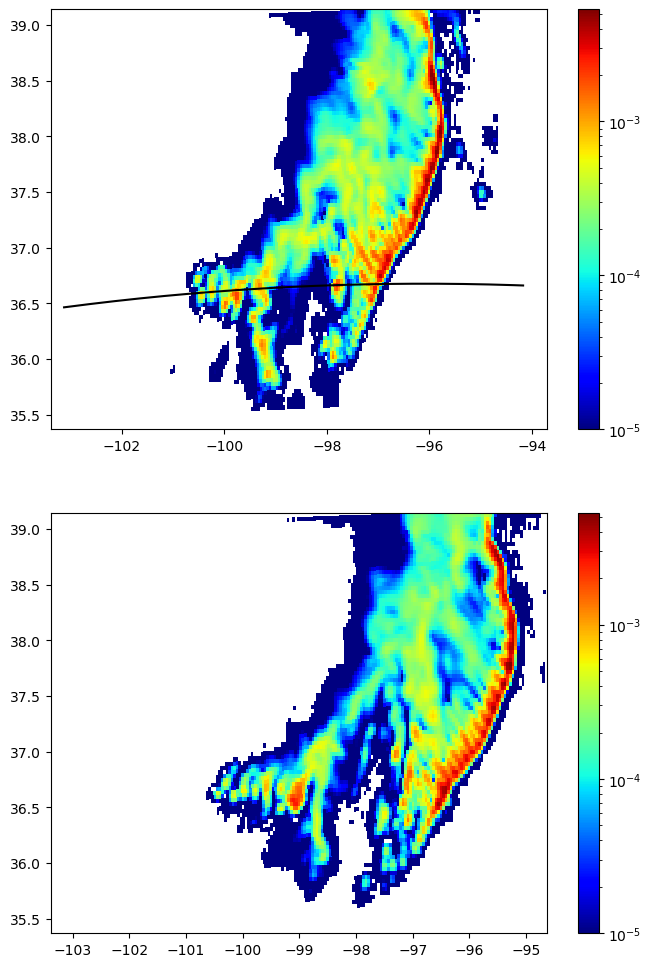

In [61]:
plt.figure(figsize=(8,12))
plt.subplot(211)
nx1=189
ny1=90
print(xlon.shape)
plt.pcolormesh(xlon[ny1:,:nx1],xlat[ny1:,:nx1],qrain[0,0,ny1:,:nx1],cmap='jet',norm=colors.LogNorm(vmin=1e-5))
plt.plot(xlon[120,:],xlat[120,:],'k')
plt.colorbar()
plt.subplot(212)
plt.pcolormesh(xlon[ny1:,:nx1],xlat[ny1:,:nx1],qrain[-1,0,ny1:,:nx1],cmap='jet',norm=colors.LogNorm(vmin=1e-5))
plt.colorbar()